## langraph is a library to build agents using nodes and edges

## State : Input schema for your node
## Node: Python Function
## Edges: Edges connect Node

In [16]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [17]:
# Step 2: Define a tool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max = 10000000))

# print(wikipedia.run("India"))

def wikipedia_tool(query: str)->str:
    """Goes to wikipedia and searches for the query
    Args:
        query (str): The query to search for
    Returns:
        str: The result of the search
    """
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max = 10000000))
    return wikipedia.run(query)

In [18]:
# Step 3: Bind an LLM to the tool
tools = [wikipedia_tool]
llm_with_tools = llm.bind_tools(tools)


#Setp 5 : Define a system message
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
# State is the input schema for the for all the nodes and edges in the graph
# System message
sys_msg = SystemMessage(content="You are a helpful assistant helps answer questions about the world using the wikipedia tool,given the user query break it down into a wikipedia keyword and use the wikipedia tool to get the answer")

# Node , overrides the graph state , here we are appending the system message with the user query
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

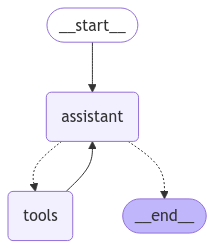

In [19]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work , these are python functions
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
messages = [HumanMessage(content="Essay on India")]
messages = react_graph.invoke({"messages": messages})

In [15]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Essay on India
================================== Ai Message ==================================
Tool Calls:
  wikipedia_tool (fdecf0d5-eb2e-43da-8f7e-2540e7cba6c1)
 Call ID: fdecf0d5-eb2e-43da-8f7e-2540e7cba6c1
  Args:
    query: India
================================= Tool Message =================================
Name: wikipedia_tool

Page: India
Summary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country from June 2023 onwards; and since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is near Sri Lanka and the Maldives; its Andaman an